# Phân cụm dữ liệu hỗn hợp bằng k-prototypes 

## BS. Lê Ngọc Khả Nhi


# Giới thiệu:

Phân cụm (Clustering) là một kỹ thuật unsupervised learning cho phép gom các đơn vị quan sát có thuộc tính tương tự nhau thành những cụm riêng biệt. Clustering hữu dụng trong thống kê mô tả, thăm dò dữ liệu và hoán chuyển đữ liệu đầu vào cho những mô hình khác. Thông thường clustering chỉ áp dụng được cho dữ liệu số, tuy nhiên ta có algorithm k-prototypes cho phép thực hiện Clustering cho dữ liệu hỗn hợp bao gồm biến định tính và định lượng. Hiện nay có 2 algorithms k-prototypes khác nhau, của Huang (1998) và Cao (2009).

Huang, Z.: Extensions to the k-modes algorithm for clustering large data sets with categorical values, Data Mining and Knowledge Discovery 2(3), pp. 283-304, 1998.

Cao, F., Liang, J, Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.

Thư viện kmodes : https://github.com/nicodv/kmodes hỗ trợ cả 2 algorithm này cho ngôn ngữ Python. Trong bài thực hành hôm nay Nhi sẽ trình diễn một thí dụ minh họa ứng dụng algorithm của Cao (2009) để phân cụm một dữ liệu gồm cả biến định lượng và định tính.

In [1]:
from kmodes.kprototypes import KPrototypes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\bacsi\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Ta sẻ sử dụng một phiên bản của bộ dữ liệu về bệnh Nhược giáp, trong đó có 6 biến định lượng và 24 biến định tính (bao gồm outcome label), với 3772 dơn vị quan sát.

Trước hết ta tải dữ liệu csv từ database openml:

In [2]:
df = pd.read_csv('https://www.openml.org/data/get_csv/21378870/sick_numeric.csv')

df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,34,1,0,0,0,0,0,0,0,0,...,1,28,1,72,1,10,0,0,1,0
1,15,1,0,0,0,0,0,0,0,0,...,1,3,0,146,0,234,0,0,4,0
2,40,2,0,0,0,0,0,0,0,0,...,1,10,1,48,1,22,0,0,4,0
3,67,1,1,0,0,0,0,0,0,0,...,1,83,0,146,0,234,0,0,4,0
4,67,1,0,0,0,0,0,0,0,0,...,1,201,1,44,1,199,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,22,1,0,0,0,0,0,0,0,0,...,0,241,0,146,0,234,0,0,4,0
3768,64,1,0,0,0,0,0,0,0,0,...,1,27,1,66,1,16,0,0,3,0
3769,71,1,0,0,0,0,0,0,0,0,...,1,14,1,65,1,6,0,0,4,0
3770,69,2,0,0,0,0,0,0,0,0,...,1,222,1,51,1,219,0,0,3,0


In [37]:
df.shape

(3772, 30)

Thư viện kmodes chỉ tiếp nhận được biến định tính đã mã hóa thành giá trị số, may mắn cho ta đó là dữ liệu đã được mã hóa sẵn

In [5]:
df.dtypes

age                          int64
sex                          int64
on_thyroxine                 int64
query_on_thyroxine           int64
on_antithyroid_medication    int64
sick                         int64
pregnant                     int64
thyroid_surgery              int64
I131_treatment               int64
query_hypothyroid            int64
query_hyperthyroid           int64
lithium                      int64
goitre                       int64
tumor                        int64
hypopituitary                int64
psych                        int64
TSH_measured                 int64
TSH                          int64
T3_measured                  int64
T3                           int64
TT4_measured                 int64
TT4                          int64
T4U_measured                 int64
T4U                          int64
FTI_measured                 int64
FTI                          int64
TBG_measured                 int64
TBG                          int64
referral_source     

Để nhận diện nhanh những biến định tính và định lượng, ta dùng phép đếm tần suất, những features nào có ít hơn 5 bậc giá trị chính là biến định tính. Ta cần phân lập column index của biến định tính (dùng khi khai báo cho hàm k-proto) và biến định lượng. Với biến định lượng, ta sẽ chuẩn hóa (cần thiết khi làm clustering)

In [19]:
df.T.apply(lambda x: x.nunique(), axis=1)

age                           94
sex                            3
on_thyroxine                   2
query_on_thyroxine             2
on_antithyroid_medication      2
sick                           2
pregnant                       2
thyroid_surgery                2
I131_treatment                 2
query_hypothyroid              2
query_hyperthyroid             2
lithium                        2
goitre                         2
tumor                          2
hypopituitary                  2
psych                          2
TSH_measured                   2
TSH                          288
T3_measured                    2
T3                            70
TT4_measured                   2
TT4                          242
T4U_measured                   2
T4U                          147
FTI_measured                   2
FTI                          235
TBG_measured                   1
TBG                            1
referral_source                5
Class                          2
dtype: int

Phân lập 2 danh sách column index cho biến định tính, định lượng:

In [55]:
unique_vals = enumerate(df.T.apply(lambda x: x.nunique(), axis=1))

cat_features = [i for i,k in unique_vals if k <= 5]

num_features = list(set(range(30)) - set(cat_features))

In [197]:
len(cat_features)

24

In [198]:
len(num_features)

6

Chuẩn hóa thang đo cho 6 biến định lượng:

In [61]:
df.iloc[:,num_features] = df.iloc[:,num_features].apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 0)

Khảo sát số lượng cluster là bao nhiêu ? Ở đây ta thăm dò các giá trị k= 1,2,3,4,5,6,7

Best run was number 1
Best run was number 6
Best run was number 2
Best run was number 10
Best run was number 8
Best run was number 2
Best run was number 10


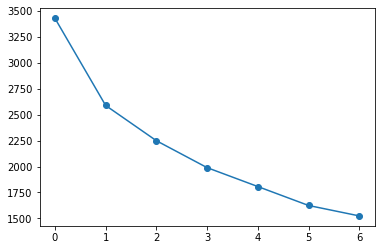

In [65]:
cost = []

for num_clusters in list(range(1,8)):
    
    # Đây là 1 quy trình clustering bằng algorithm Cao, sử dụng tất cả CPU
    
    kproto = KPrototypes(n_clusters=num_clusters, 
                         init='Cao',
                         verbose=1,
                         random_state=123,
                         n_jobs=-2)
    
    kproto.fit_predict(df.values, 
                       categorical=cat_features)
    
    cost.append(kproto.cost_)

plt.plot(cost, 'o-')

Theo kết quả này, số lượng cluster tối ưu là 2, ta áp dụng hàm Kprototypes cho dữ liệu, chú ý khai báo list columns index cho biến định tính khi fit mô hình

In [95]:
k2 = KPrototypes(n_clusters=2,
                  max_iter=100,
                  init='Cao',
                  n_init=100,
                  verbose=1,
                  random_state=123,
                  n_jobs=-2,)

k2.fit(df.values,
       categorical=cat_features)

Best run was number 41


KPrototypes(cat_dissim=<function matching_dissim at 0x0000017C896345E8>,
            gamma=0.2641592610754961, init='Cao', max_iter=100, n_clusters=2,
            n_init=100, n_jobs=-2,
            num_dissim=<function euclidean_dissim at 0x0000017C89634D38>,
            random_state=123, verbose=1)

Mô hình sau khi fit có thể dùng để dán nhãn cluster cho một dữ liệu khác trong trường hợp bạn tách riêng trainset và testset

In [96]:
df['Cluster'] = k2.predict(df.values, categorical=cat_features)

Xem thông tin centroids

In [103]:
k2.cluster_centroids_

[array([[0.47523974, 0.54109764, 0.48104006, 0.74032853, 0.55063105,
         0.93793306, 2.1659496 ],
        [0.51601875, 0.3633326 , 0.42782338, 0.32206714, 0.37902417,
         0.12073197, 0.77948718]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 0., 0., 4., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 0., 0., 4., 0.]])]

Danh sách nhãn cluster cho dữ liệu train cũng có thể trích xuất từ thuộc tính labels_

In [106]:
k2.labels_

array([1, 0, 1, ..., 1, 0, 0], dtype=uint16)

Sau khi có kết quả phân cụm, bạn có thể chơi với nó thoải mái, thí dụ vẽ một biểu đồ 3 chiều để khảo sát phân bố của 3 biến định lượng Age, TSH và TT4 và quan hệ với 2 cluster:

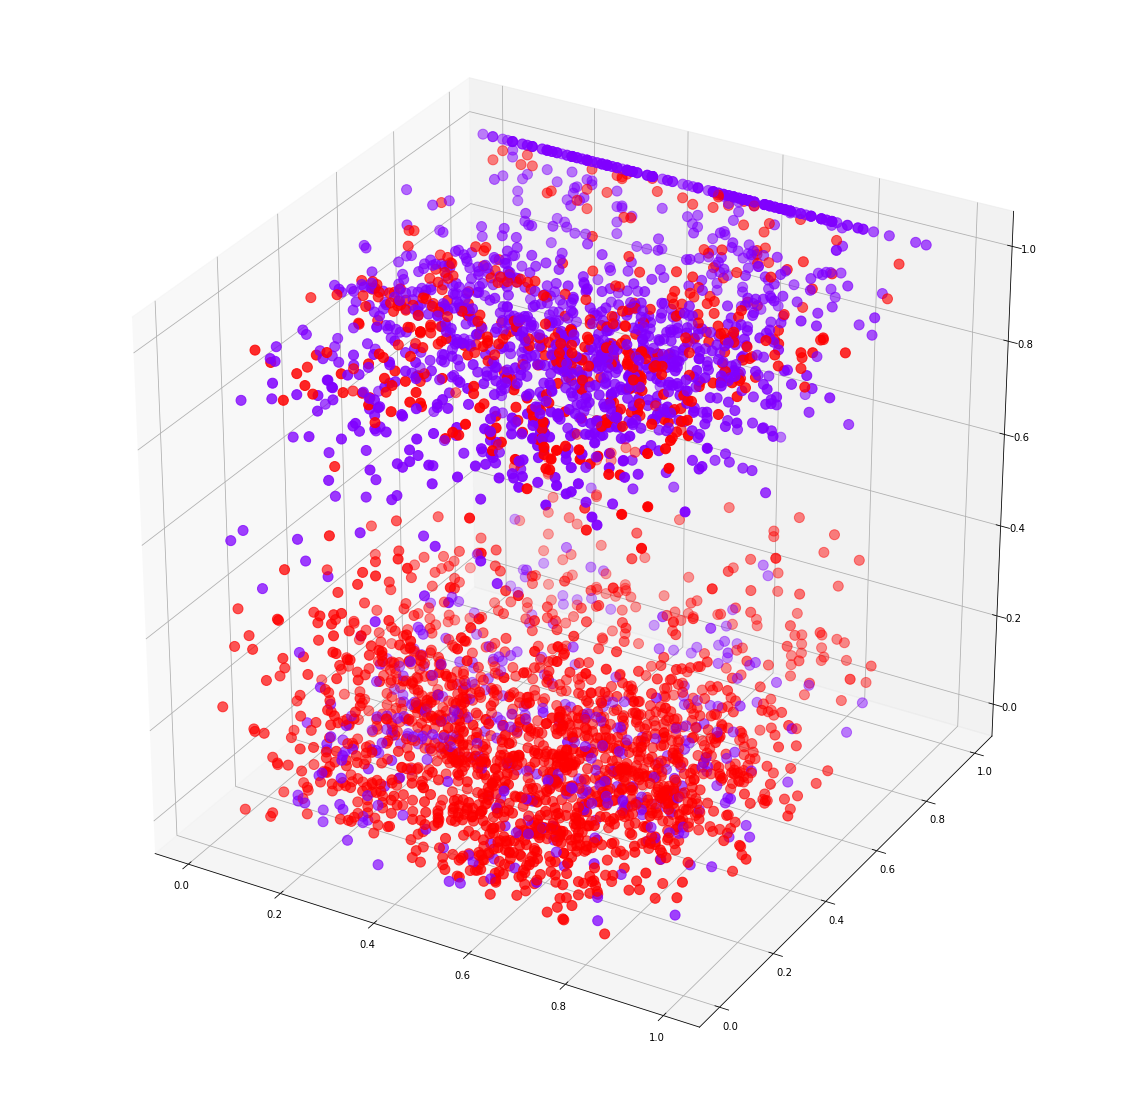

In [112]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.age,
           df.TSH, 
           df.TT4, 
           c = k2.labels_,  # 
           s=100, 
           cmap = plt.get_cmap('rainbow'))

Bạn cũng có thể khảo sát đặc tính phân bố của các biến định tính trong mỗi cluster bằng biểu đồ thanh:

In [181]:
def cross_tab(df,x,y, ax):
    ct = pd.crosstab(df[x], df[y])
    stacked = ct.stack().reset_index().rename(columns={0:'frequency'})
    sns.barplot(x=stacked[y], y=stacked.frequency, hue=stacked[x], ax = ax)

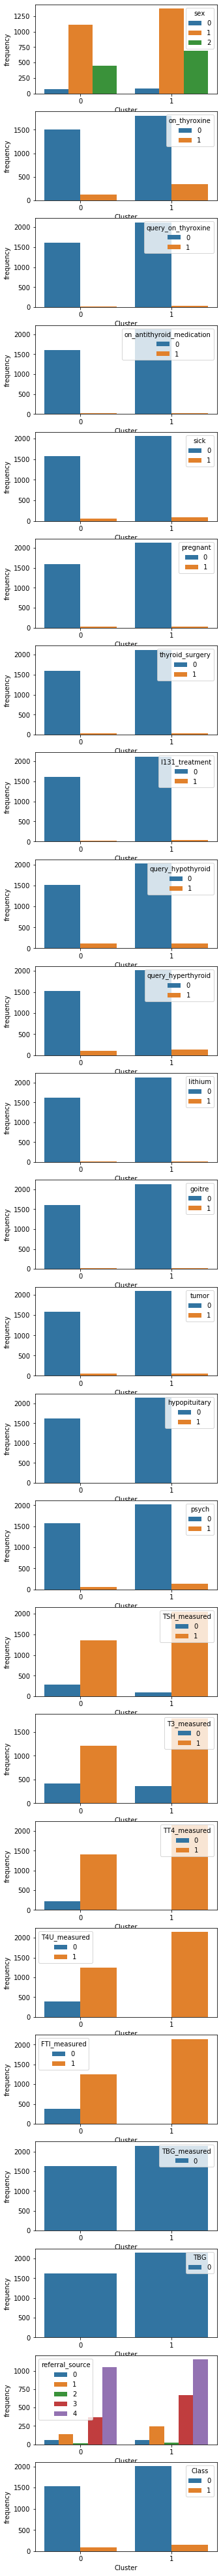

In [185]:
fig, axs = plt.subplots(nrows=len(cat_features), figsize=(5,24*3))

for i,v in enumerate(df.iloc[:,cat_features].columns):
    g = cross_tab(df, v, 'Cluster', ax = axs[i])

Tương tự, ta có thể so sánh phân bố của các biến định lượng trong mỗi cluster bằng boxplot:

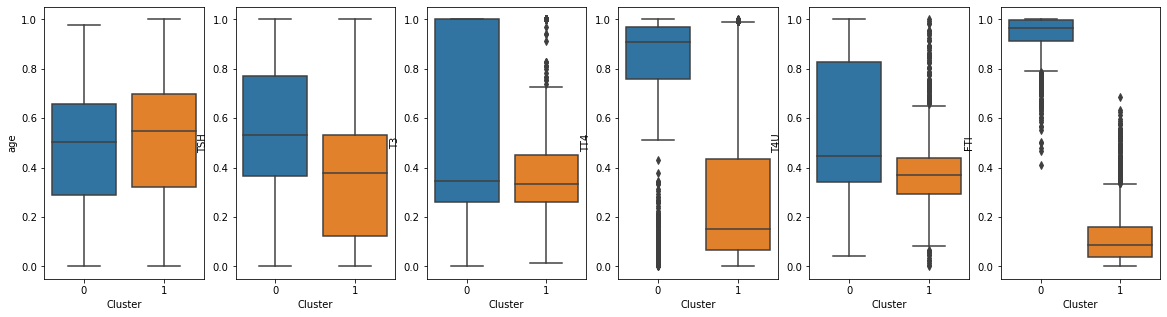

In [196]:
fig, axs = plt.subplots(ncols=len(num_features), figsize=(20,5))

for i,v in enumerate(df.iloc[:,num_features].columns):
    g = sns.boxplot(x=df.Cluster, y = df[v], ax = axs[i])

Bài thực hành đến đây tạm dừng, bạn đã có trong tay một công cụ mới rất linh hoạt cho phép phân cụm bất cứ dữ liệu nào

Chúc các bạn thực hành vui và hẹn gặp lần tới.